In [1]:
# !pip install --upgrade pandas

In [2]:
!pip install pyarrow

     |████████████████████████████████| 58.1MB 19kB/s  eta 0:00:011    |██████████▎                     | 18.7MB 8.5MB/s eta 0:00:05     |██████████████▎                 | 25.9MB 8.5MB/s eta 0:00:04
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
#!pip install scikit-plot

In [4]:
import pandas as pd
import numpy as np
#from numpy import nan as NA
import os
import gc
from sklearn.model_selection import train_test_split
#from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

from azure.storage.blob import BlockBlobService
import pyarrow.parquet as pq
from io import StringIO
from io import BytesIO

%matplotlib inline

In [5]:
#Azure account credentials
azure_storage_account_name = "agedatasciencecocstorage"
azure_storage_account_key = "V/FXG+lIWtYc854wbRA8BxGCLGJijS0NDwLvNHfmAxqRopAL3WHWGIQoHxpArG9lZoX+iY+dvtPYoB379w4MIw=="

if azure_storage_account_name is None or azure_storage_account_key is None:
    raise Exception("You must provide a name and key for an Azure Storage account")

In [6]:
# First, we need to connect to our blob via the BlobService
blob_service = BlockBlobService(azure_storage_account_name, azure_storage_account_key)
# There are also methods to list containers and blobs
#containers = blob_service.list_containers()
blobs = blob_service.list_blobs('banking-dm')

In [7]:
# # List the blobs in the container.
# print("\nList blobs in the container")
# #generator = block_blob_service.list_blobs(container_name)
# for blob in blobs:
#     print("\t Blob name: " + blob.name)

### Read Data

In [8]:
container_name = "banking-dm"

In [9]:
blob_name_parquet = 'ailiev/3M_AVG_MCIF_2018-01__2018-03.parquet.gzip' 
byte_stream = BytesIO()
try:
    blob_service.get_blob_to_stream(container_name=container_name, blob_name=blob_name_parquet, stream=byte_stream)
    df = pq.read_table(source=byte_stream).to_pandas()
    # Do work on df ...
finally:
    # Add finally block to ensure closure of the stream
    byte_stream.close()

In [10]:
df.shape

(100215, 278)

In [11]:
df.head()

,Customer_ID,AGE_MONTHS,SECTOR,CUSTOMER_ECO_BRANCH,MARITAL_STATUS,GENDER,CUSTOMER_CATEGORY,CUSTOMER_TYPE,AT_LEAST_ONE_ACTIVE,AVG_DEPOSITS_minus_LOANS,...,TOTAL_SAVING_BAL,TOTAL_SAVING_CNT,TOTAL_TNAM,CLOSED_MONTHS_MIN,DC_MATURE_MONTHS_MAX,MATURE_MONTHS_MAX,MATURE_MONTHS_MIN,MONTHS_TILL_EXP_MAX,MONTHS_TILL_EXP_MIN,AVG_PERIOD
0,1,558,Arts and Communications,BR160,Divorced,F,None,Individual,0.666667,157.725083,...,37.805250,1.0,1026.335000,-1,-1,54,0,-1,-1,2018-01--2018-03
1,2,519,Finance,BR09,Married,M,None,Professional,1.000000,0.000000,...,0.000000,1.0,161.413333,-1,59,215,213,-1,-1,2018-01--2018-03
2,3,310,Manufacturing,BR145,Married,M,None,Individual,1.000000,1616.158533,...,1616.158533,1.0,3606.596667,-1,-1,229,227,-1,-1,2018-01--2018-03
3,4,484,Health and Science,BR14,None,None,Retail,Small Business,1.000000,-271.317717,...,208.618900,1.0,3869.115000,-1,93,120,0,17,-18,2018-01--2018-03
4,5,477,Agriculture and Food,BR171,Single,M,None,Individual,1.000000,-836.073333,...,0.000000,1.0,1923.821667,-1,-1,171,68,2,-1,2018-01--2018-03


In [12]:
pd.value_counts(df['CUSTOMER_TYPE'])

Individual        84302
Small Business    15410
Professional        503
Name: CUSTOMER_TYPE, dtype: int64

In [13]:
#remove SBBs
df = df[df['CUSTOMER_TYPE']=="Individual"]

In [14]:
df.shape

(84302, 278)

In [15]:
blob_name_parquet_label = 'ailiev/MG_Offer_5.parquet.gzip'
byte_stream = BytesIO()
try:
    blob_service.get_blob_to_stream(container_name=container_name, blob_name=blob_name_parquet_label, stream=byte_stream)
    label = pq.read_table(source=byte_stream).to_pandas()
    # Do work on df ...
finally:
    # Add finally block to ensure closure of the stream
    byte_stream.close()

In [16]:
label.shape

(84302, 2)

In [17]:
label.head()

,Customer_ID,MG_OFFER
0,1,1
2,3,1
4,5,1
5,6,1
6,7,1


In [18]:
df = df.merge(label, on="Customer_ID")

In [19]:
df.head()

,Customer_ID,AGE_MONTHS,SECTOR,CUSTOMER_ECO_BRANCH,MARITAL_STATUS,GENDER,CUSTOMER_CATEGORY,CUSTOMER_TYPE,AT_LEAST_ONE_ACTIVE,AVG_DEPOSITS_minus_LOANS,...,TOTAL_SAVING_CNT,TOTAL_TNAM,CLOSED_MONTHS_MIN,DC_MATURE_MONTHS_MAX,MATURE_MONTHS_MAX,MATURE_MONTHS_MIN,MONTHS_TILL_EXP_MAX,MONTHS_TILL_EXP_MIN,AVG_PERIOD,MG_OFFER
0,1,558,Arts and Communications,BR160,Divorced,F,None,Individual,0.666667,157.725083,...,1.0,1026.335000,-1,-1,54,0,-1,-1,2018-01--2018-03,1
1,3,310,Manufacturing,BR145,Married,M,None,Individual,1.000000,1616.158533,...,1.0,3606.596667,-1,-1,229,227,-1,-1,2018-01--2018-03,1
2,5,477,Agriculture and Food,BR171,Single,M,None,Individual,1.000000,-836.073333,...,1.0,1923.821667,-1,-1,171,68,2,-1,2018-01--2018-03,1
3,6,291,Hospitality and Tourism,BR67,Married,M,None,Individual,1.000000,-6204.040000,...,1.0,3386.038333,-1,85,106,59,12,-1,2018-01--2018-03,1
4,7,438,Health and Science,BR152,Other,M,None,Individual,1.000000,5062.585717,...,2.0,6010.791667,-1,78,118,0,-1,-1,2018-01--2018-03,1


In [20]:
df.shape

(84302, 279)

### Analysis

In [21]:
del df['AVG_PERIOD']

In [22]:
demographic_columns = ['Customer_ID', 'CUSTOMER_TYPE', 'CUSTOMER_CATEGORY', 'GENDER', 'MARITAL_STATUS', 'CUSTOMER_ECO_BRANCH', 'SECTOR', 'AGE_MONTHS', 
                      'MG_OFFER']

In [23]:
indep_columns = [col for col in df.columns if col not in demographic_columns]

In [24]:
len(indep_columns)

269

In [25]:
#replaces inf with nan
df.replace( -np.inf, np.nan, inplace=True)

In [26]:
df.fillna(0, inplace=True)

In [27]:
# Create independent and target sets
independents = df[indep_columns].values
target = df['MG_OFFER'].values

In [26]:
# Simple implementation of the (normalized) gini score in numpy
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest) with a second key to sort ambiguities
    df = pd.DataFrame({'y_true':y_true,'y_pred':y_pred, 'count':np.arange(n_samples)})
        
    true_order = df.sort_values(by=['y_true','count'], ascending=(False,True))['y_true']
    pred_order = df.sort_values(by=['y_pred','count'], ascending=(False,True))['y_true']


    # get Lorenz curves
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(0, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred/G_true

In [29]:
# Parameter tuning function
# Trains multiple models on train dataset and evaluates on test dataset. Tries different combination of LogReg parameters.
# Returns accuracy table; best parameters
def parameter_tuning(independents, target, test_size, random_state=0):
    X_train, X_test, y_train, y_test = train_test_split(independents, target, test_size=test_size, random_state=0)
    C_param_range = [1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+00, 1.e+01, 1.e+03, 1.e+05]
    Penalty_param = ['l1', 'l2']

    acc_table = pd.DataFrame(columns = ['C_parameter', 'Penalty_parameter', 'GINI', 'AUC', 'Accuracy'])
    C_param = [val for val in C_param_range for _ in (0, 1)]
    acc_table['C_parameter'] = C_param
    acc_table['Penalty_parameter'] = Penalty_param*len(C_param_range)

    best_param = []
    best_GINI = 0
    j = 0
    for c in C_param_range:
        for p in Penalty_param:
            # Apply logistic regression model to training data
            lr = LogisticRegression(penalty = p, C = c,random_state = 0)
            lr.fit(X_train,y_train)

            # Predict using model
            y_pred = lr.predict(X_test)
            y_pred_proba=lr.predict_proba(X_test)[:,1]
            roc_auc = metrics.roc_auc_score(y_test, y_pred_proba)
            gini = Gini(y_test, y_pred_proba)

            # Saving accuracy score in table
            acc_table.iloc[j,2] = gini
            acc_table.iloc[j,3] = roc_auc
            acc_table.iloc[j,4] = metrics.accuracy_score(y_test,y_pred)
            j += 1
            print('.')
            
            # Saving Best Parameters
            if gini > best_GINI:
                best_GINI = gini
                best_param = lr.get_params()
    return acc_table, best_param

In [28]:
# Highlights max values of columns
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [30]:
# Calculate accuracy table; best parameters.
# Different split of train/test samples can be tried, plus different seeds.
%time acc_table, best_param = parameter_tuning(independents, target, 0.3, random_state=0)
acc_table.style.apply(highlight_max, subset=['GINI', 'Accuracy', 'AUC'])

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
CPU times: user 40min 40s, sys: 30.5 s, total: 41min 10s
Wall time: 41min 11s


In [28]:
X_train, X_test, y_train, y_test = train_test_split(independents, target, test_size=0.25, random_state=13579)

In [29]:
# Train model with best parameters
lr = LogisticRegression(penalty = 'l1', C = 1000, random_state = 0)
lr.fit(X_train,y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [54]:
prob_y=lr.predict_proba(X_test) #calculate score probabilities - needed for AUC
prob_y=[p[1] for p in prob_y]

In [57]:
metrics.roc_auc_score(y_test, prob_y)

0.7224459195858579

In [33]:
prob_y=lr.predict_proba(X_test) #calculate score probabilities - needed for AUC
prob_y=[p[1] for p in prob_y]

In [34]:
pred_lr = lr.predict(X_test)

In [36]:
print(metrics.classification_report(y_test, pred_lr,target_names=["False", "True"]))

             precision    recall  f1-score   support

      False       0.90      1.00      0.95     19038
       True       0.21      0.00      0.00      2038

avg / total       0.84      0.90      0.86     21076



In [38]:
confusion = metrics.confusion_matrix(y_test, pred_lr)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[19027    11]
 [ 2035     3]]


In [39]:
!pip install scikit-plot
import scikitplot as skplt

     |████████████████████████████████| 286kB 7.2MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


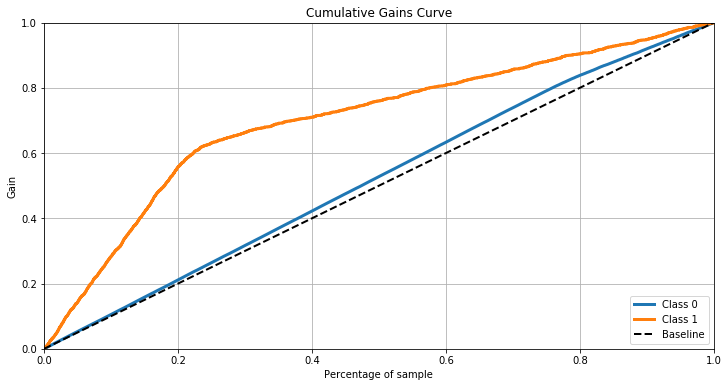

In [40]:
predicted_probas = lr.predict_proba(X_test)
plt.rcParams["figure.figsize"] = (12,6)
skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
plt.show()

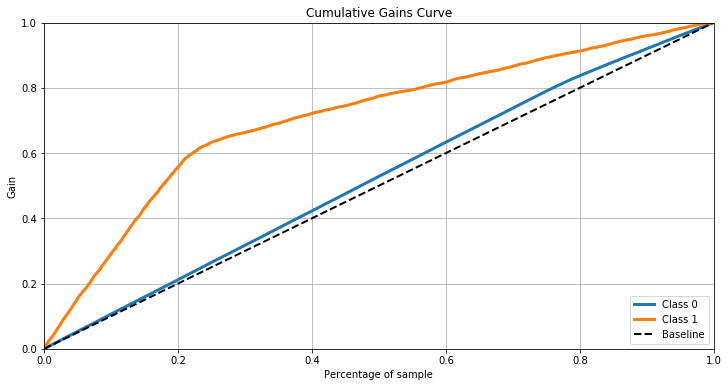

In [41]:
predicted_probas_train = lr.predict_proba(X_train)
skplt.metrics.plot_cumulative_gain(y_train, predicted_probas_train)
plt.show()

In [42]:
indep_columns = [col for col in df.columns if col not in demographic_columns]

In [52]:
lr.coef_.shape

(1, 269)

In [53]:
#tree feature importance
features = pd.DataFrame(lr.coef_.T, columns=['Value'], index=indep_columns)
features.sort_values('Value', ascending=False, inplace=True)

In [54]:
def plot_feature_importances(model, top_n):
    model = model.head(top_n)
    n_features = model.shape[0]
    plt.barh(range(n_features), model['Value'], align='center')
    plt.yticks(np.arange(n_features), model.index)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

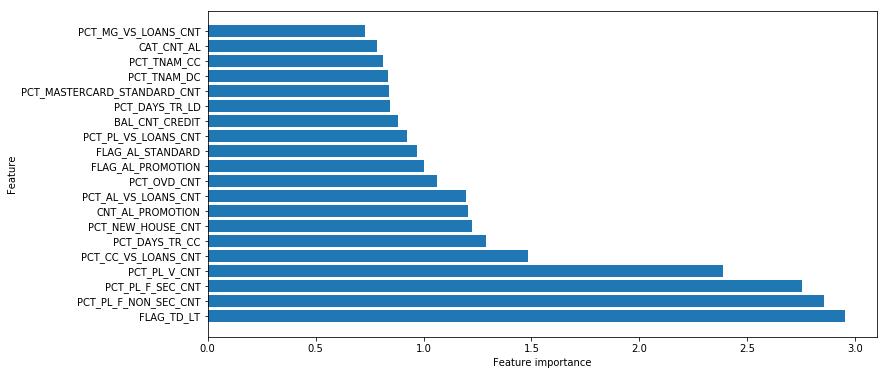

In [55]:
plot_feature_importances(features, 20)